### 1. 대화내용 불러오기

In [1]:
from gensim.models import ldaseqmodel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim import corpora
from tqdm import notebook
from time import time

import pandas as pd
import numpy as np
import pickle
import os
from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data
with open("data/cleaned_katalk_data.pk", "rb") as f:
    data = pickle.load(f)

# 시간정보 열을 datetime 정보로 변환
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

data.head()

,user,message
date,,
2016-03-07 15:41:00,YH,안녕하세요 이게 빠르지 않을까 해서요 엠티 관련해서는 회장님께서 이미 밴드에 올려 ...
2016-03-07 15:51:00,WH,네 안녕하세요
2016-03-07 17:14:00,YH,넵 저희 카톡방을 만들어서 거기다 투표를 돌릴까요 아님 그냥 밴드에 두개로 할까요 총무님
2016-03-07 17:21:00,KS,엠티관련해서 참석여부 투표를 말씀하신건가요
2016-03-07 17:22:00,YH,네 저희 이번 토욜 관련해서도 투표를 올려야 해서요


In [4]:
# 시기별로 데이터 나누기
data_0 = data['2016-03-01' : '2016-03-31']
data_1 = data['2016-04-01' : '2016-04-20']
data_2 = data['2016-04-21' : '2016-04-30']

# 시기별 데이터 가져오기
slice0 = list(data_0['message'])
slice1 = list(data_1['message'])
slice2 = list(data_2['message'])

# 모든 분석 대상 텍스트를 담는 리스트
tokenized_data = [msg.split() for msg in (slice0 + slice1 + slice2)]

# 각 slice에 들어 있는 갯수를 원소로 갖는 리스트 생성
time_slice = []
time_slice.append(len(slice0))
time_slice.append(len(slice1))
time_slice.append(len(slice2))

In [5]:
# 저장된 DTM dictionary, corpus 불러오기
dictionary = Dictionary.load('data/kakao_DTM_dict')
corpus = bleicorpus.BleiCorpus('data/kakao_DTM_corpus')

### coherence score 계산 (주의 : 시간 매우 오래 걸림)

#### topic 개수 지정하기.

In [6]:
# 토픽 4개 ~ 8개일 경우 coherence score 계산

# 각 3개 시간대별로 5가지 경우 (총 3 * 5 = 15)

start=4; end=9; step=1;  # topic 수 4 ~ 8
times=[0, 1, 2]

#### DTM과 coherence score 계산하는 함수

In [7]:
def compute_coherence(dictionary, corpus, texts, times, start, end, step):
    coherence_score_list = []
    model_list = []
    
    for num_topics in notebook.tqdm(range(start, end, step)):
        ###################
        start_dtm = time()
        
        # 각 토픽마다 DTM 계산
        dtm_name = "data/kakao_dtm_model_" + str(num_topics)
        
        # 하나씩 계산될 때마다 파일로 저장
        # 여기 passes 값 주의. 시간을 줄이기 위해 작게 설정.
        # token 16만개, passes=100 인 경우 각 토픽마다 DTM 계산시 5시간 소요.
        if os.path.exists(dtm_name):
            dtm_model = ldaseqmodel.LdaSeqModel.load(dtm_name)
        else:
            dtm_model = ldaseqmodel.LdaSeqModel(corpus=corpus,
                                                id2word=dictionary,
                                                time_slice=time_slice,
                                                num_topics=num_topics, passes=50)
            dtm_model.save(dtm_name)
            
        end_dtm = time()
        print("Elapsed Time for DTM in %d topics : %.2f sec." % (num_topics, (end_dtm - start_dtm)))
        
        ################### 
        # coherence score 계산
        topic_cs_list = []
        for time_slot in times:
            topics_dtm = dtm_model.dtm_coherence(time=time_slot)
            cs = CoherenceModel(topics=topics_dtm, 
                                texts=texts,
                                dictionary=dictionary, 
                                coherence='c_v')
            topic_cs_list.append(cs.get_coherence())
            
        ################### 
        model_list.append(dtm_model)
        coherence_score_list.append(topic_cs_list)
        
    return model_list, coherence_score_list

In [8]:
model_list, coherence_scores = compute_coherence(dictionary=dictionary, 
                                                 corpus=corpus, 
                                                 texts=tokenized_data,
                                                 times=times,
                                                 start=start, end=end, step=step)

Elapsed Time for DTM in 4 topics : 753.78 sec.
Elapsed Time for DTM in 5 topics : 814.11 sec.
Elapsed Time for DTM in 6 topics : 869.47 sec.
Elapsed Time for DTM in 7 topics : 970.75 sec.
Elapsed Time for DTM in 8 topics : 1034.14 sec.



##### 위 계산 결과 통째로 저장

In [9]:
import pickle

with open("data/kakao_dtm_models.pk", 'wb') as f:
    pickle.dump(model_list, f)
    
with open("data/kakao_dtm_cs.pk", 'wb') as f:
    pickle.dump(coherence_scores, f)

In [10]:
import pickle

with open("data/kakao_dtm_models.pk", 'rb') as f:
    model_list = pickle.load(f)
    
with open("data/kakao_dtm_cs.pk", 'rb') as f:
    coherence_scores = pickle.load(f)

### 5. Topic Coherence 변화 그래프 그리기

In [11]:
pprint(coherence_scores)

[[0.682627308726258, 0.682627308726258, 0.6834405723040877],
 [0.7053417683768004, 0.7053417683768004, 0.7053417683768004],
 [0.7168548384468222, 0.7168548384468222, 0.7165706010320069],
 [0.7214187596601532, 0.7219102868296178, 0.7222625292745228],
 [0.7173526392942438, 0.7193519408013308, 0.7193090619250999]]


In [12]:
# 편한 연산을 위해 numpy array로 변경.
import numpy as np

np_coherence_scores = np.array(coherence_scores) 
np_cs_avg_list = np_coherence_scores.mean(axis=1)

In [13]:
np_cs_avg_list

array([0.6828984 , 0.70534177, 0.71676009, 0.72186386, 0.71867121])

In [14]:
# 그래프 출력을 위한 한글 글꼴 설정.

import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

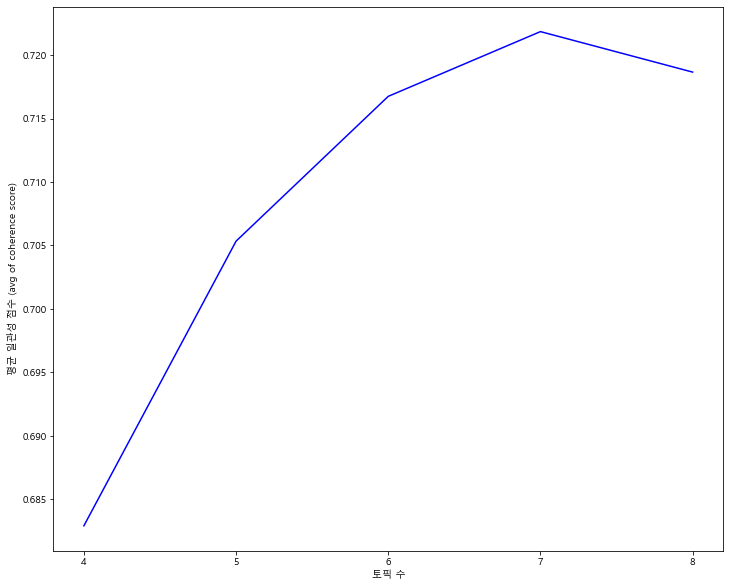

In [29]:
# 그래프 그리기
x = range(start, end, step)

plt.figure(figsize=(12, 10)) 
plt.plot(x, np_cs_avg_list, '-b')
plt.xlabel("토픽 수")
plt.ylabel("평균 일관성 점수 (avg of coherence score)")
plt.xticks(x)
plt.show()

##### 위에서 구한 일관성 점수 기준으로 최적 토픽 모델 결정

In [16]:
# 최적 토픽 모델을 dtm_model로 할당
dtm_model = model_list[np.argmax(np_cs_avg_list)]
len(dtm_model.print_topics())

# 토픽 7개인 경우(dtm_model_7) coherence score가 가장 높음.

7

##### DTM 결과 보기

In [28]:
# 특정 시간대의 전체 토픽보기
pprint(dtm_model.print_topics(time=1, top_terms=10))

[[('나', 0.03344893288674591),
  ('왜', 0.024047638215209784),
  ('진짜', 0.0173723623229852),
  ('응', 0.013522996025803433),
  ('좀', 0.013516010862522158),
  ('근데', 0.01344012587927944),
  ('역시', 0.010272112451785453),
  ('아직', 0.009811067674001243),
  ('넵', 0.00875013652421433),
  ('내가', 0.007712988737483256)],
 [('그럼', 0.02545967507800263),
  ('내가', 0.0194247890647761),
  ('그래', 0.015087896137907552),
  ('다들', 0.013877791400952457),
  ('오', 0.011726965476322045),
  ('그거', 0.00974663550206747),
  ('아니야', 0.009015495045961323),
  ('없어', 0.007241197778231521),
  ('이미', 0.006689363699285501),
  ('이', 0.005859643337448443)],
 [('아', 0.05623053882418802),
  ('나도', 0.02830143286851737),
  ('더', 0.012685614341995256),
  ('완전', 0.011947987599918403),
  ('누나', 0.009700306692628427),
  ('저거', 0.009547528727417199),
  ('내일', 0.009432451211299831),
  ('아니', 0.009021452433987746),
  ('많이', 0.008318001651011047),
  ('하고', 0.008073321187592158)],
 [('우리', 0.026422071007503968),
  ('내', 0.01682738502169

In [30]:
# 특정 토픽의 시간대별 변화 보기
dtm_model.print_topic_times(topic=0, top_terms=10)

[[('나', 0.03304209694926037),
  ('왜', 0.023877064312210247),
  ('진짜', 0.017144435810603955),
  ('좀', 0.01388458956816079),
  ('근데', 0.013329606438307592),
  ('응', 0.013259308053801615),
  ('역시', 0.010140073523240015),
  ('아직', 0.009699643022283481),
  ('넵', 0.008815864204293996),
  ('내가', 0.007665218475732778)],
 [('나', 0.03344893288674591),
  ('왜', 0.024047638215209784),
  ('진짜', 0.0173723623229852),
  ('응', 0.013522996025803433),
  ('좀', 0.013516010862522158),
  ('근데', 0.01344012587927944),
  ('역시', 0.010272112451785453),
  ('아직', 0.009811067674001243),
  ('넵', 0.00875013652421433),
  ('내가', 0.007712988737483256)],
 [('나', 0.033816708414789905),
  ('왜', 0.024191943791049563),
  ('진짜', 0.01761018664642402),
  ('응', 0.013864547387638664),
  ('근데', 0.013555867878687303),
  ('좀', 0.013166824883927446),
  ('역시', 0.010397512812373274),
  ('아직', 0.009547127812730783),
  ('넵', 0.008680986684372775),
  ('내가', 0.007755850505890038)]]

### 6. 문서별 토픽 비중 구하기

> 1) 토픽 비중 계산을 위한 데이터 전처리

> 2) OOM (out of memory) 문제 해결을 위한 샘플링 - 문서 3,000 개

> 3) DataFrame으로 만들어 excel 파일로 저장

In [19]:
# 문서에 시간대 정보 추가
doc_time = []

for doc_id in range(len(tokenized_data)):
    if doc_id < time_slice[0]:
        doc_time.append(0)
    elif doc_id < time_slice[0] + time_slice[1]:
        doc_time.append(1)
    else:
        doc_time.append(2)
        
print(len(doc_time))

14911


In [20]:
# OOM 문제로 인해 time_slot 별로 1000개씩 문서 샘플링.

sample_idx1 = np.random.randint(0, time_slice[0], size=1000)
sample_idx2 = np.random.randint(time_slice[0], time_slice[0] + time_slice[1], size=1000)
sample_idx3 = np.random.randint(time_slice[0] + time_slice[1], time_slice[0] + time_slice[1] + time_slice[2], size=1000)

print(sample_idx1[:10])
print(sample_idx2[:10])
print(sample_idx3[-10:])

[1000  329   90  252  322  739  149  992  648  593]
[5634 3999 4607 5333 2732 5626 2370 6151 4801 6511]
[11724 13540 13308 12300 12137  7300  9623 14656  9440  7441]


In [21]:
processing_docs = []
processing_time = []

sample_indices = np.concatenate((sample_idx1, sample_idx2, sample_idx3))

for idx in sample_indices:
    processing_docs.append(tokenized_data[idx])
    processing_time.append(doc_time[idx])
    
print(len(processing_docs))
print(len(processing_time))

3000
3000


In [22]:
# 문서별로 각 토픽에 속할 확률 계산
doc_dist = []

for doc_id in sample_indices:
    # DTM 모델에서 문서별 토픽 확률을 반환받아 리스트에 저장.
    doc_dist.append(dtm_model.doc_topics(doc_id)) 

In [23]:
doc_dist = np.array(doc_dist)
doc_topic_dist = doc_dist.T   # dataframe 만들기 위해 transpose !!!
doc_topic_dist.shape

(7, 3000)

In [24]:
NUM_TOPICS = dtm_model.num_topics

for i in range(NUM_TOPICS):
    print("%f" % doc_dist[0][i], end=", ")

print()

for i in range(NUM_TOPICS):
    print("%f" % doc_topic_dist[i][0], end=", ")

0.991513, 0.001414, 0.001414, 0.001414, 0.001414, 0.001414, 0.001414, 
0.991513, 0.001414, 0.001414, 0.001414, 0.001414, 0.001414, 0.001414, 

In [25]:
doc_topic_dist[0].shape

(3000,)

In [31]:
dtm_df = pd.DataFrame({"Time" : processing_time, "Topic0" : doc_topic_dist[0], "Topic1" : doc_topic_dist[1],
                       "Topic2" : doc_topic_dist[2], "Topic3" : doc_topic_dist[3], "Topic4" : doc_topic_dist[4],
                       "Topic5" : doc_topic_dist[5], "Topic6" : doc_topic_dist[6]
                      })

print(dtm_df.head())

dtm_df.to_excel("data/kakao_dtm_8topic_dist.xlsx")

   Time    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5    Topic6
0     0  0.991513  0.001414  0.001414  0.001414  0.001414  0.001414  0.001414
1     0  0.004831  0.004831  0.004831  0.004831  0.971014  0.004831  0.004831
2     0  0.002457  0.985258  0.002457  0.002457  0.002457  0.002457  0.002457
3     0  0.971014  0.004831  0.004831  0.004831  0.004831  0.004831  0.004831
4     0  0.001239  0.001239  0.001239  0.001239  0.001239  0.992565  0.001239


### 7. 시간별 토픽비중 변화 추이

> 1) 토픽 비중 변화를 보기 위한 데이터 전처리

> 2) 시간대별 토픽 비중 평균 계산

##### timeslot별로 평균 구하기

In [32]:
# 시간대로 grouping
doctopic_timeslot = dtm_df.groupby('Time')
doctopic_timeslot.groups

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...], 1: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1

In [33]:
# mean() 함수 이용해서 Topic0~TopicN까지의 모든 열 평균 구하기
timeslot_avg = doctopic_timeslot.mean()
timeslot_avg = timeslot_avg.reset_index()   # index 리셋하기
timeslot_avg

,Time,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6
0,0,0.137947,0.144965,0.144357,0.172725,0.129046,0.119060,0.151900
1,1,0.130116,0.135278,0.148573,0.153854,0.152273,0.143311,0.136594
2,2,0.137308,0.151043,0.139662,0.151950,0.157687,0.136787,0.125565


In [34]:
# 시간대별 모든 토픽 값의 합은 1
timeslot_avg.sum(axis=1)

0    1.0
1    2.0
2    3.0
dtype: float64

### 8. 6번, 7번 결과로 그래프 그리기

#### 시간별 토픽 비중변화 추이

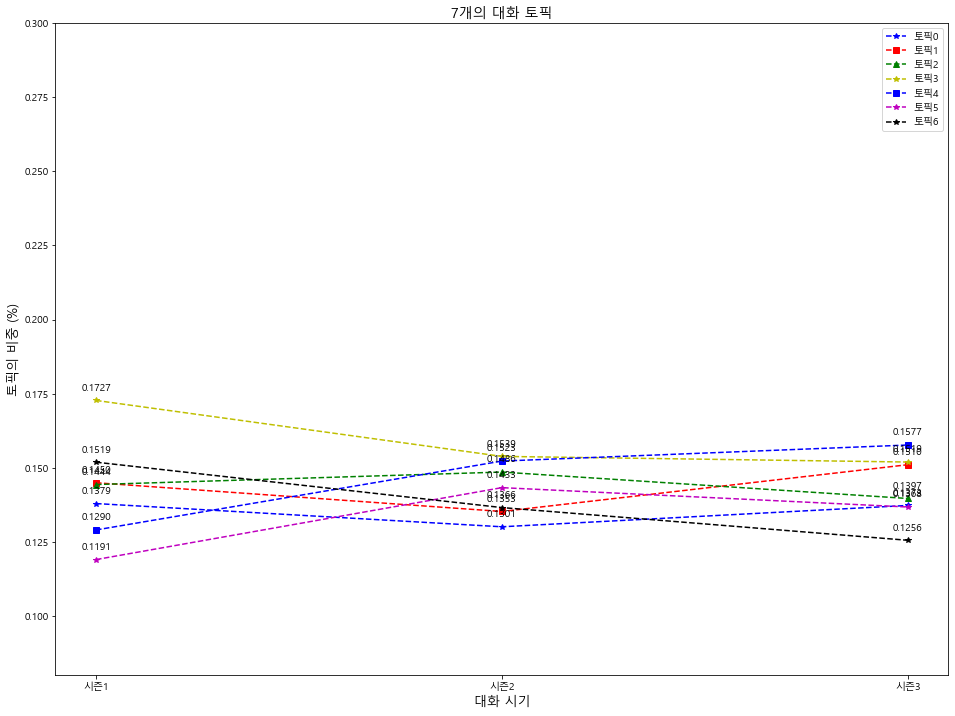

In [35]:
# figure 하나당 4개씩 그래프 그리기

plt.figure(figsize=(16, 12)) 
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic0'], 'b*--', label='토픽0')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic1'], 'rs--', label='토픽1')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic2'], 'g^--', label='토픽2')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic3'], 'y*--', label='토픽3')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic4'], 'bs--', label='토픽4')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic5'], 'm*--', label='토픽5')
plt.plot(timeslot_avg['Time'], timeslot_avg['Topic6'], 'k*--', label='토픽6')

# 그래프에서 값 표시하는 annotate 방법 찾기
for topic_id in ['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6']:
    for x, y in zip(range(len(time_slice)), timeslot_avg[topic_id]):
        plt.annotate("%.4f"%y, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("7개의 대화 토픽", fontsize=14)
plt.xlabel("대화 시기", fontsize=13)
plt.ylabel("토픽의 비중 (%)", fontsize=13)
plt.xticks(timeslot_avg['Time'], ['시즌1', '시즌2', '시즌3'])
plt.ylim([0.08, 0.30])
plt.legend(loc="best")
plt.savefig("data/kakao_topic_distribution_graph.png")
plt.show()

#### 시간별 단어의 토픽 비중변화 추이

In [36]:
from collections import defaultdict

# 단어의 확률 변화를 보고 싶은 topic 번호 
topic_id = 3

# 해당 토픽에서 포함할 단어목록 결정
topic_info = dtm_model.print_topic_times(topic=topic_id, top_terms=50)
topic_dict = defaultdict(list)

# time별 특정 topic(topic_id)의 단어별 확률값.
for dist_inTime in topic_info:
    # time별로 단어와 확률값 저장.
    for word, prob in dist_inTime:
        topic_dict[word].append(prob)

In [42]:
print(topic_dict)

defaultdict(<class 'list'>, {'우리': [0.026211389113910723, 0.026422071007503968, 0.026612070807653217], '내': [0.01629010879321055, 0.016827385021693658, 0.016776831610079607], '그래서': [0.01062401899598899, 0.010756640493143987, 0.010945190198581357], '네': [0.009269537526994618, 0.009114851447649834, 0.008999017638749154], '이제': [0.008634791382456633, 0.00879067423074816, 0.008704514738868675], '다시': [0.008332217720734997, 0.008351432405176516, 0.008344639551209931], '저': [0.006726680961857097, 0.006670824903114447, 0.006607113913536232], '넹': [0.0064707811904160415, 0.006480175129868676, 0.006399169073581151], '젤': [0.006004894855005111, 0.0060491903887788315, 0.006104099206409116], '누가': [0.004693768178679034, 0.004723822182990429, 0.0047559269540669614], '이게': [0.004534304132713559, 0.00454287456387314, 0.004553376170123953], '보람이': [0.004441786827584651, 0.004473074409214207, 0.004506048940603244], '전': [0.004167329220324157, 0.00416285759886086, 0.004145867655853018], '일단': [0.004132

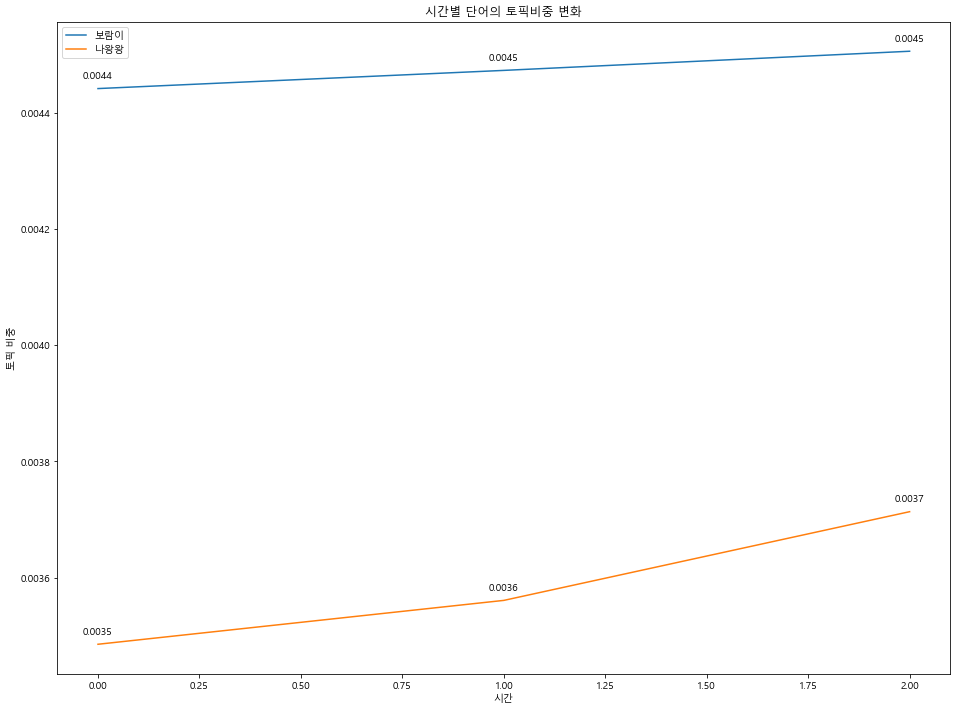

In [46]:
# 확률값 추이를 보고싶은 단어 목록
keywords = ["보람이", "나왕왕"]

# time_slot
t = [i for i in range(len(time_slice))]

plt.figure(figsize=(16, 12))
for keyword in keywords:
    plt.plot(t, topic_dict[keyword], label=keyword)
    
    for x, y in zip(t, topic_dict[keyword]):
         plt.annotate("%.4f"%y, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.title("시간별 단어의 토픽비중 변화")
plt.xlabel("시간")
plt.ylabel("토픽 비중")
plt.legend(loc='best')
plt.savefig("data/kakao_keywords_distribution_overtime_graph.png")
plt.show()